# Tail Modelling for Bootstrap Hypothesis Testing with Generalized Pareto Distribution
## **for more accurate estimation of small p-values, as needed e.g. for FDR correction**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### 1. Generate sample data

In [7]:
random = np.random.default_rng(42)

# Parameters
n_samples = 40
true_corr = -0.1
mean = [0, 0]
cov = [[1, true_corr], [true_corr, 1]]  # covariance matrix 

# Generate the data
data = random.multivariate_normal(mean, cov, n_samples)
df = pd.DataFrame(data, columns=['X', 'Y'])

# Calculate the actual correlation
actual_corr = df.corr().iloc[0, 1]
print(f"Actual correlation: {actual_corr}")

Actual correlation: -0.25053582069004604


### Step 2: Bootstrap Hypothesis Testing

In [8]:
n_bootstrap = 10000
bootstrap_corrs = []

for _ in range(n_bootstrap):
    # Resample with replacement
    bootstrap_sample = df.sample(n=n_samples, replace=True)
    # Calculate correlation of the bootstrap sample
    bootstrap_corr = bootstrap_sample.corr().iloc[0, 1]
    bootstrap_corrs.append(bootstrap_corr)

# Convert bootstrap correlations to a numpy array
bootstrap_corrs = np.array(bootstrap_corrs)

### 3. Calculate confidence interval and "conventional" p-values:

In [9]:
# Calculate 95% confidence interval
ci_lower = np.percentile(bootstrap_corrs, 2.5)
ci_upper = np.percentile(bootstrap_corrs, 97.5)
print(f"95% Confidence Interval for correlation: ({ci_lower}, {ci_upper})")
# calculate p-values
n_gt0 = np.sum(bootstrap_corrs > 0)
p_value_liberal = n_gt0 / n_bootstrap
p_value_conservative = (n_gt0+1) / (n_bootstrap+1)
print(f"Liberal p-value:        {p_value_liberal}")
print(f"Conservative p-value:   {p_value_conservative}")

95% Confidence Interval for correlation: (-0.49127794878542935, 0.06336309652948166)
Liberal p-value:        0.0561
Conservative p-value:   0.056194380561943806


### 4. Tail modelling-based p-values

In [10]:
tail_ratio = 0.10
extreme_value = 0  # now we want the p-value for the correlation being larger than 0 (but it could be any other value)

# Identify the tail
threshold = np.quantile(bootstrap_corrs, 1-tail_ratio)
tail_data = bootstrap_corrs[bootstrap_corrs > threshold]
# Fit the Generalized Pareto Distribution (GPD)
c, loc, scale = stats.genpareto.fit(tail_data - threshold)
# calculate the p-value
excess_value = extreme_value - threshold
p_value = (1 - stats.genpareto.cdf(excess_value, c, loc=loc, scale=scale)) * tail_ratio # we mltiply by the tail ratio to account for the fact that we only consider the tail
print(f"GPD parameters: shape={c}, loc={loc}, scale={scale}")
print(f"P-value with tail modelling: {p_value}")

GPD parameters: shape=-0.11609029879140115, loc=1.1589488792407444e-05, scale=0.08813894328961056
P-value with tail modelling: 0.05623108279160809


### 5. Plot the distribution of bootstrap correlations and the tail model

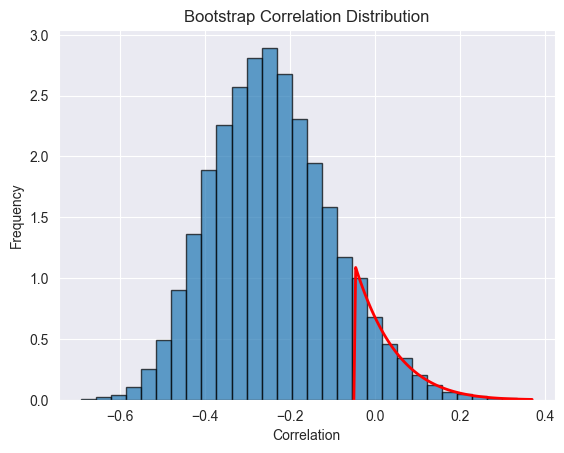

In [11]:
# Plot the distribution of bootstrap correlations
plt.hist(bootstrap_corrs, bins=30, edgecolor='k', alpha=0.7, density=True)
plt.title('Bootstrap Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
    
# Plot the fitted GPD versus the empirical tail data
x = np.linspace(threshold, tail_data.max(), 100)
y = stats.genpareto.pdf(x - threshold, c, loc=loc, scale=scale)
plt.plot(x, y*tail_ratio, 'r-', lw=2, label='Fitted GPD')